## Topic:
Analyze financial data to show which companies are the top “winners" and “losers” from the Covid19 outbreak, and why. 

#### assumption:
Covid19 outbreak starts from around 3.9(3.10)


## 0. reload data (offline)

In [381]:
import pandas as pd
import json 
df_final_losers = pd.read_csv('losers_correlation_with_death.csv')
df_final_winners = pd.read_csv('winners_correlation_with_death.csv')
data_all = pd.read_csv('data_from_YahooFinance.csv')
winners_df = pd.read_csv('winners_sector_industry.csv')
losers_df = pd.read_csv('losers_sector_industry.csv') = json.loads(open())
positive_news = json.loads(open('positive_news.txt',"r").read())
negative_news = json.loads(open('negative_news.txt',"r").read())

## 1. Data Scraping (online)

I analyze the winners and losers from SP 500.

In [46]:

import numpy as np
from matplotlib import pyplot as plt
import requests 
from bs4 import BeautifulSoup 
import datetime
import seaborn as sns
import re
import bs4 as bs
import pickle
import requests
def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux i686) AppleWebKit/537.17 (KHTML, like Gecko) Chrome/24.0.1312.27 Safari/537.17'}
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies',
                        headers=headers)
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
#     with open("sp500tickers.pickle","wb") as f:
#         pickle.dump(tickers,f)
    return tickers
sp_list = [x.replace('\n','') for x in save_sp500_tickers()]

In [274]:
import yfinance as yf
data = yf.download(sp_list, start="2020-03-10", end="2020-05-13")
data_return = data['Close'].pct_change()
benchmark_sp500 = yf.download('^GSPC', start="2020-03-10", end="2020-05-13")['Close'].pct_change()
data_all = pd.concat([data_return, benchmark_sp500], axis=1)
data_all.rename(columns={'Close':'SP500'},inplace =True)

[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed


## 2. Data Analysis

### 2.0 Data Cleaning

#### use heatmap to see whether there are some missing data

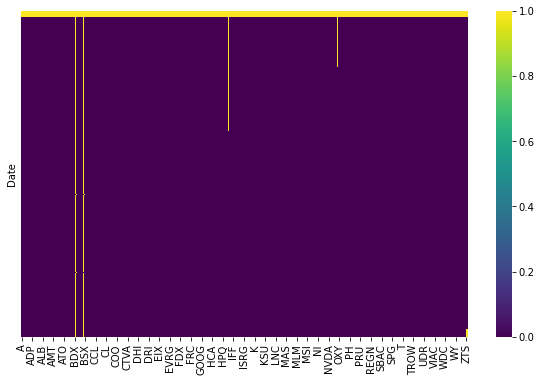

In [275]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(data_all.isnull(), yticklabels=False, cbar=True, cmap='viridis') 
plt.show() 

#### from above heatmap we can see that some stock has nearly all missing points and some points have half missing points and maybe one stock has 1 missing point. so I did imputation with dfferent methods in order

In [276]:
data_all.dropna(how='all',inplace=True)
data_all.fillna(method='ffill',inplace=True) #use forward fill to fill nan values. 
data_all.dropna(how='any',axis=1,inplace=True) #drop nan value by column 

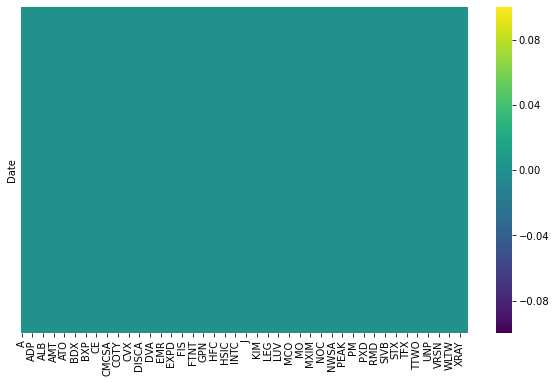

In [277]:
plt.figure(figsize=(10,6))
sns.heatmap(data_all.isnull(), yticklabels=False, cbar=True, cmap='viridis') 
plt.show() 

now it has no nan values

### 2.1 Define winners and losers

In [8]:
all_stocks_return = (data_all+1).cumprod().iloc[-1][:-1]
sp500_return = (data_all+1).cumprod().iloc[-1][-1]

In [9]:
winners_return = all_stocks_return[all_stocks_return>sp500_return]
losers_return = all_stocks_return[all_stocks_return<sp500_return]
winners = data_all[winners_return.index]
losers = data_all[losers_return.index]

### 2.2 Scrape winners(losers) sector and industry

In [10]:

def find_ind_sector(winner_names,loser_names):
    winnners_info=dict()
    losers_info = dict()
    for name in winner_names:
        resp = requests.get('https://money.cnn.com/quote/profile/profile.html?symb='+name)
        soup = bs.BeautifulSoup(resp.content, 'lxml')
        sector = soup.find('table',{'id':'wsod_sectorIndustry'}).find_all('td')[0].find('div').get_text()
        industry = soup.find('table',{'id':'wsod_sectorIndustry'}).find_all('td')[1].find('div').get_text()
        market = soup.find('table',{'id':'wsod_sectorIndustry'}).find_all('td')[2].find('div').get_text()
        winnners_info[name] = {'sector':sector,'industry':industry,'market':market}
    for name in loser_names:
        resp = requests.get('https://money.cnn.com/quote/profile/profile.html?symb='+name)
        soup = bs.BeautifulSoup(resp.text, 'html')
        sector = soup.find('table',{'id':'wsod_sectorIndustry'}).find_all('td')[0].find('div').get_text()
        industry = soup.find('table',{'id':'wsod_sectorIndustry'}).find_all('td')[1].find('div').get_text()
        market = soup.find('table',{'id':'wsod_sectorIndustry'}).find_all('td')[2].find('div').get_text()
        losers_info[name] = {'sector':sector,'industry':industry,'market':market}
    return winnners_info,losers_info


In [11]:
# this will take a long time. So u can skip this and reload in the begining
winners_dict,loser_dict=find_ind_sector(winners.columns,losers.columns)

now we can visualize the performance of different sectors and industries in winners group and losers group

In [410]:
winners_df = pd.DataFrame.from_dict({i:winners_dict[i] for i in winners_dict.keys()},orient='index')
losers_df = pd.DataFrame.from_dict({i:loser_dict[i] for i in loser_dict.keys()},orient='index')
winners_return.name='total_return'
winners_df=pd.concat([winners_df,winners_return-1],axis=1)
losers_return.name='total_return'
losers_df=pd.concat([losers_df,losers_return-1],axis=1)

Text(0.5, 1.0, 'winners__sector_mean_return')

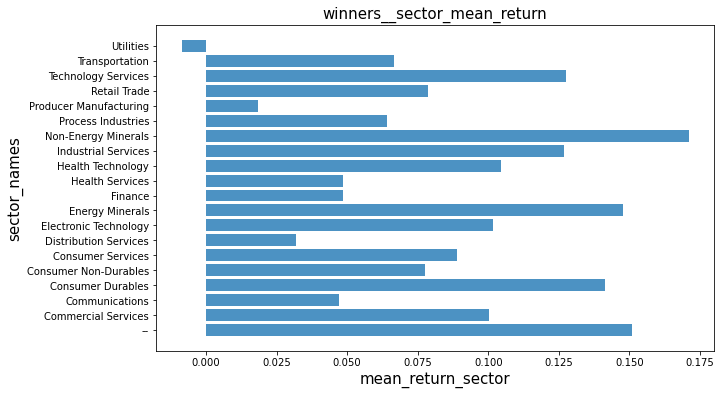

In [30]:
plt.figure(figsize=(10,6))
ax=plt.gca()
names = winners_df.groupby('sector')['total_return'].mean().index
winners_df_mean = winners_df.groupby('sector')['total_return'].mean()
ax.barh(names,winners_df_mean,alpha=0.8)
ax.set_ylabel('sector_names',fontsize=15)
ax.set_xlabel('mean_return_sector',fontsize=15)
ax.set_title('winners__sector_mean_return',fontsize=15)

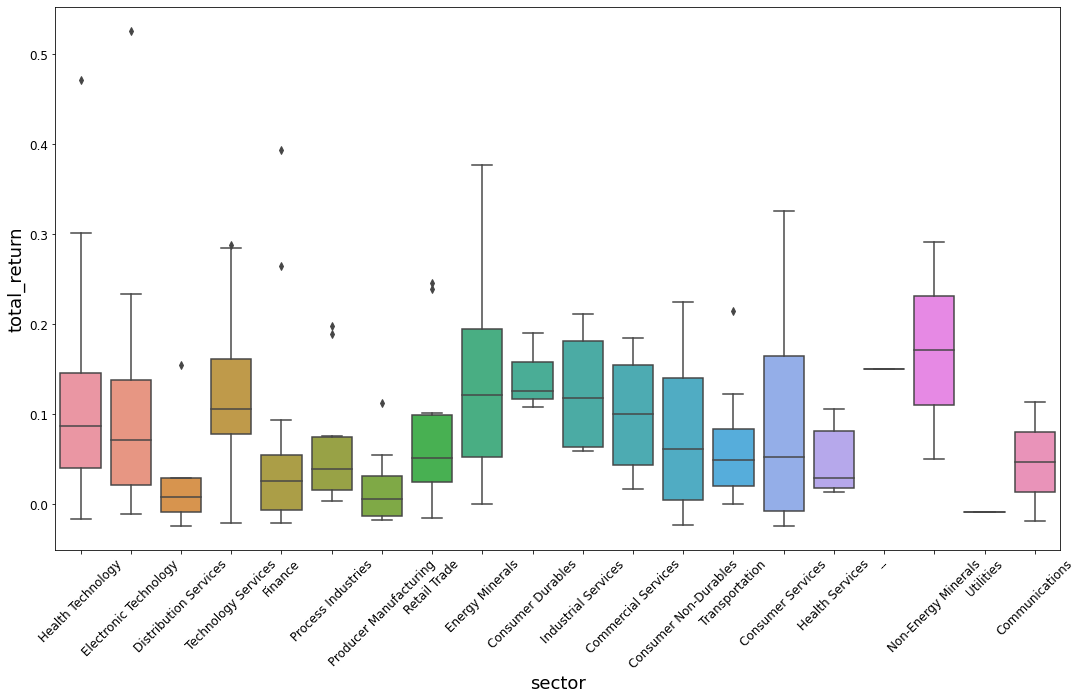

In [32]:
plt.figure(figsize=(18, 10))
plt.tick_params('both', labelsize='12')
plt.xticks(rotation=45)
plt.xlabel('sector',fontsize=18)
plt.ylabel('total_return',fontsize=18)
sns.boxplot(x="sector", y="total_return", data=winners_df)

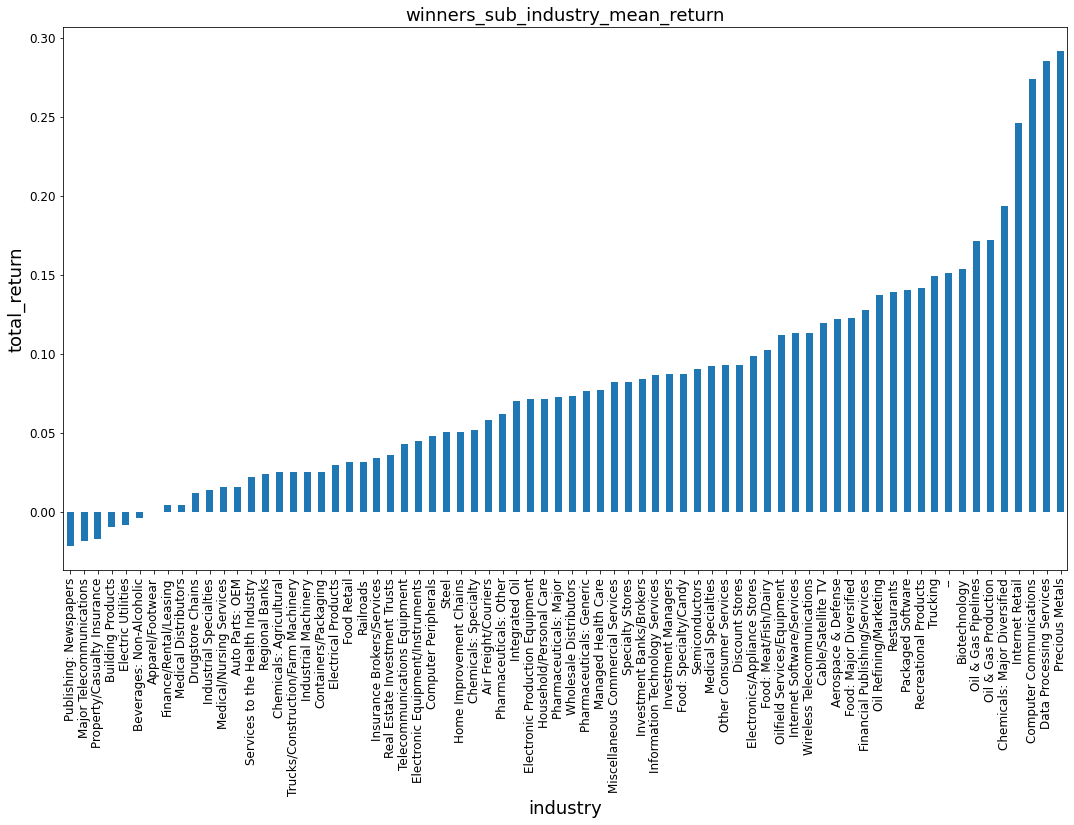

In [38]:
plt.figure(figsize=(18, 10))
plt.tick_params('both', labelsize='12')
plt.title('winners_sub_industry_mean_return',fontsize=18)
plt.xlabel('industry',fontsize=18)
plt.ylabel('total_return',fontsize=18)
winners_df.groupby("industry")['total_return'].mean().sort_values().plot.bar()

Text(0.5, 1.0, 'losers_sector_mean_return')

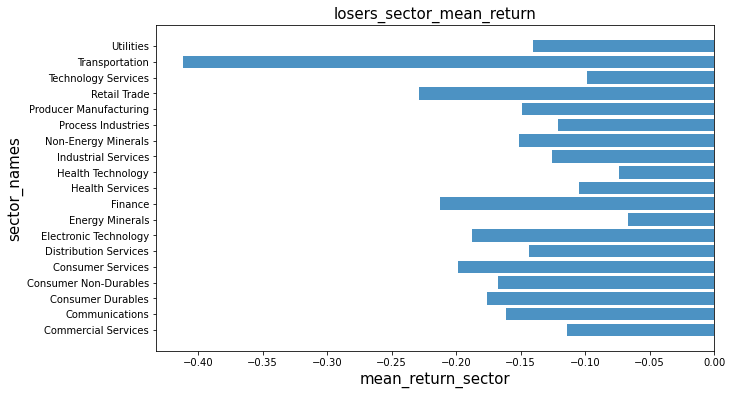

In [31]:
plt.figure(figsize=(10,6))
ax=plt.gca()
names_loser = losers_df.groupby('sector')['total_return'].mean().index
losers_df_mean = losers_df.groupby('sector')['total_return'].mean()
ax.barh(names_loser,losers_df_mean,alpha=0.8)
ax.set_ylabel('sector_names',fontsize=15)
ax.set_xlabel('mean_return_sector',fontsize=15)
ax.set_title('losers_sector_mean_return',fontsize=15)

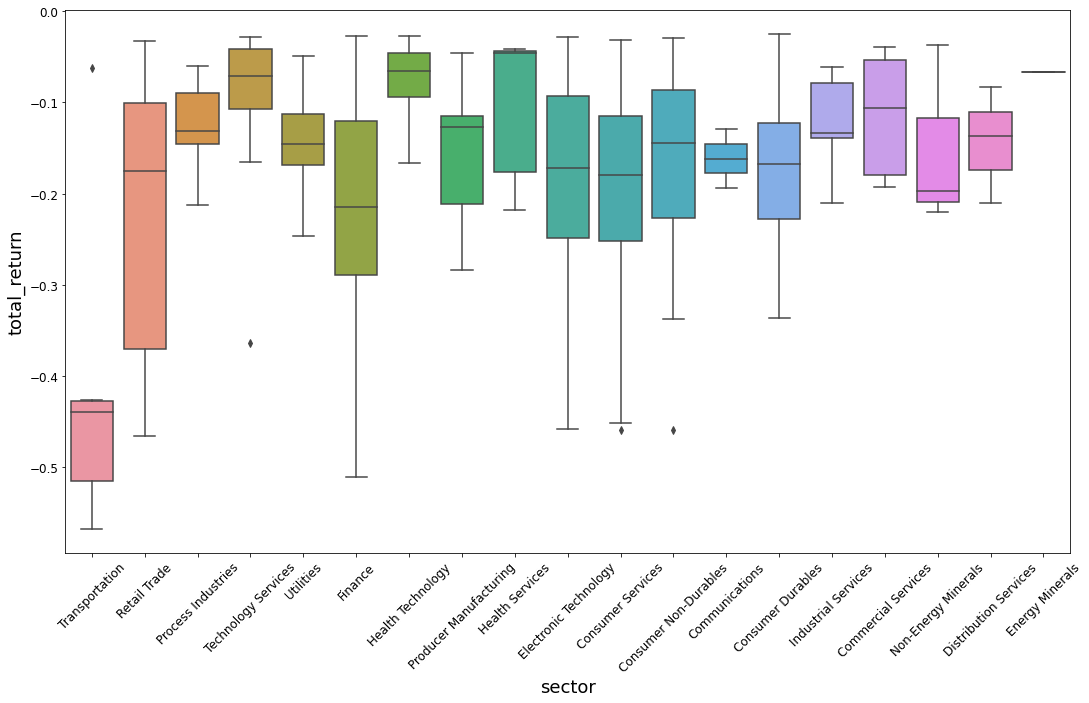

In [28]:
plt.figure(figsize=(18, 10))
plt.tick_params('both', labelsize='12')
plt.xticks(rotation=45)
plt.xlabel('sector',fontsize=18)
plt.ylabel('total_return',fontsize=18)
sns.boxplot(x="sector", y="total_return", data=losers_df)

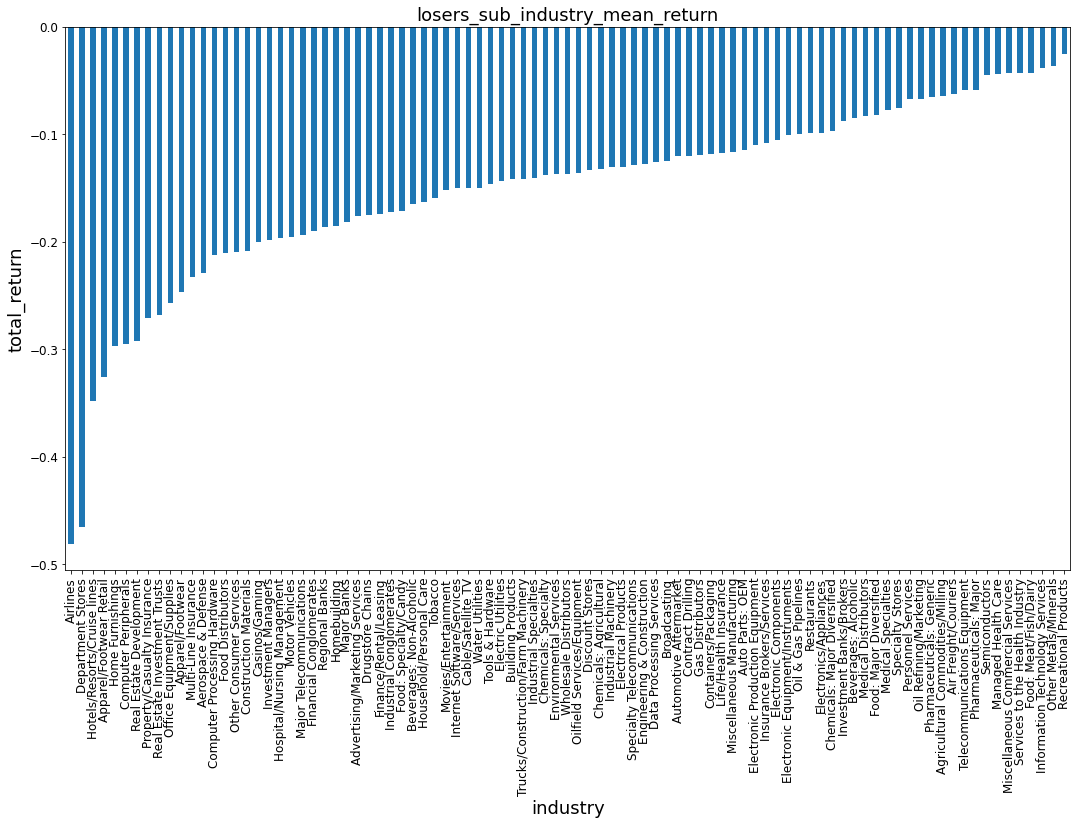

In [40]:
plt.figure(figsize=(18, 10))
plt.tick_params('both', labelsize='12')
plt.title('losers_sub_industry_mean_return',fontsize=18)
plt.xlabel('industry',fontsize=18)
plt.ylabel('total_return',fontsize=18)
losers_df.groupby("industry")['total_return'].mean().sort_values().plot.bar()

In [155]:
for i in names:
    if i not in names_loser:
        print(i)

--


From the comparison picture, we can know that winners sotcks and losers stocks cover all sectors.

In [16]:
losers_df_mean = losers_df.groupby('sector')['total_return'].mean()
winners_df_mean = winners_df.groupby('sector')['total_return'].mean()
winners_df_mean.sort_values()[-6:].index # because '--' does not belong to any sector

Index(['Industrial Services', 'Technology Services', 'Consumer Durables',
       'Energy Minerals', '--', 'Non-Energy Minerals'],
      dtype='object', name='sector')

In [17]:
losers_df_mean.sort_values()[:5].index

Index(['Transportation', 'Retail Trade', 'Finance', 'Consumer Services',
       'Electronic Technology'],
      dtype='object', name='sector')

From above analysis, we can see that there are still some sectors that perform significantly better during this time. In the meantime, some sectors perform worse.

| Top_5_winners_sector | Top_5_losers_sector  | 
| --- | --- | 
| Industrial Services | Transportation |
| Technology Services | Retail Trade|
|Consumer Durables |Finance|
|Energy Minerals|Consumer Services|
|Non-Energy Minerals|Electronic Technology|


### 2.3 Test correlation between corona virus and winners(losers) 

In [227]:
#from datetime import datetime
import math
import scipy.stats as st

In [91]:
def get_latest_death_recover_us(url):
    resp = requests.get(url)
    soup = bs.BeautifulSoup(resp.content, 'html')
    death = soup.find('table',{'id':'main_table_countries_today'}).find_all('td',{'style':"font-weight: bold; text-align:right;"})[0].get_text()
    recover = soup.find('table',{'id':'main_table_countries_today'}).find_all('td', {'style':"font-weight: bold; text-align:right"})[1].get_text()
    return int(death.replace(',','')),int(recover.replace(',',''))
death,recover = get_latest_death_recover_us('https://www.worldometers.info/coronavirus')

In [189]:
# TO GET daily data of deaths in this COVID19
df = pd.read_csv('daily-deaths-covid-19.csv') # this file comes from this url: https://ourworldindata.org/grapher/daily-deaths-covid-19?time=2020-03-09..2020-05-14
df['Date']=df['Date'].apply(lambda x:datetime.datetime.strptime(x,'%d-%b-%y'))
df_sub = df.groupby('Date')['Daily confirmed deaths (deaths)'].sum()[69:]
winners_all = winners.join(df_sub)`
losers_all = losers.join(df_sub)

Text(0.5, 1.0, 'losers_retern vs death')

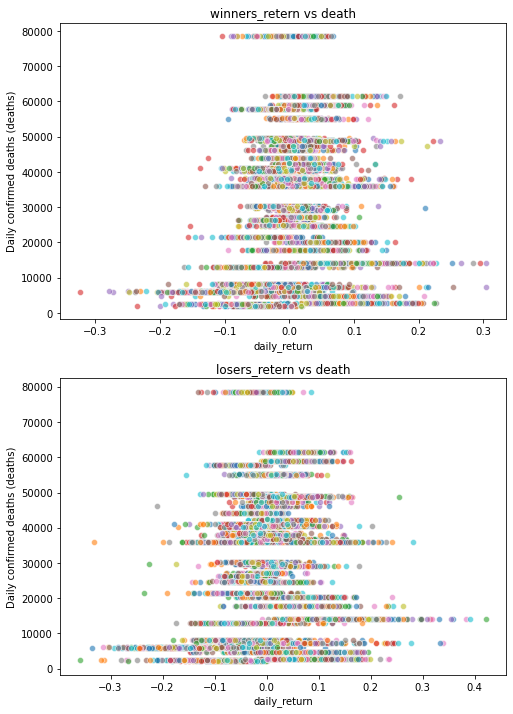

In [197]:
fig, ax = plt.subplots(2,1, figsize=(8,12))
company_list_winners = []
corr_list_winners = []
company_list_losers = []
corr_list_losers = []
x_values=winners_all['Daily confirmed deaths (deaths)']
for name in winners_all.columns[:-1]:
    y_values=winners[name]
    correlation = st.pearsonr(x_values,y_values)
    sns.scatterplot(y_values,x_values,ax=ax[0],alpha=0.6)
    company_list_winners.append(name)
    corr_list_winners.append(round(correlation[0],2))
ax[0].set_xlabel('daily_return')
ax[0].set_title('winners_retern vs death')
x_values=losers_all['Daily confirmed deaths (deaths)']
for name in losers_all.columns[:-1]:
    y_values=losers[name]
    correlation = st.pearsonr(x_values,y_values)
    sns.scatterplot(y_values,x_values,ax=ax[1],alpha=0.6)
    company_list_losers.append(name)
    corr_list_losers.append(round(correlation[0],2))
ax[1].set_xlabel('daily_return')
ax[1].set_title('losers_retern vs death')


### 2.4 save data

In [218]:
df_final_winners = pd.DataFrame({'Company':company_list_winners,
                        'Correlation':corr_list_winners})
df_final_losers = pd.DataFrame({'Company':company_list_losers,
                        'Correlation':corr_list_losers})

In [380]:
df_final_losers.to_csv('losers_correlation_with_death.csv')
df_final_winners.to_csv('winners_correlation_with_death.csv')
data_all.to_csv('data_from_YahooFinance.csv')
winners_df.to_csv('winners_sector_industry.csv')
losers_df.to_csv('losers_sector_industry.csv')

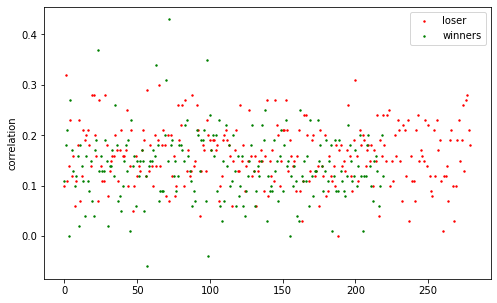

In [217]:
# correlation chart
plt.figure(figsize=(8,5))
plt.scatter(range(len(corr_list_losers)),corr_list_losers,color='r',label='loser',s=2)
plt.scatter(range(len(corr_list_winners)),corr_list_winners,color='g',label='winners',s=2)
plt.ylabel('correlation')
plt.legend()

from this charter we can know that some companies return correlates with the degree of spread of COVID-19 to some extent. And some other companies have no such correlation. 

In [241]:
# now we export winners companies that have correlation > 0.3
winners_df.loc[df_final_winners[df_final_winners['Correlation']>0.3]['Company']]

,sector,industry,market,total_return
APA,Energy Minerals,Oil & Gas Production,$4.7B,0.092678
DGX,Health Services,Services to the Health Industry,$15.0B,0.013918
DXCM,Health Technology,Medical Specialties,$37.4B,0.471452
EBAY,Consumer Services,Other Consumer Services,$29.5B,0.165372
HOLX,Health Technology,Medical Specialties,$13.4B,0.132475


In [242]:
#export losers companies that have high correlation
losers_df.loc[df_final_losers[df_final_losers['Correlation']>0.3]['Company']]

,sector,industry,market,total_return
AAP,Retail Trade,Specialty Stores,$8.6B,-0.079142
PHM,Consumer Durables,Homebuilding,$8.1B,-0.291194


In [259]:
# winners that sorted by values 
winners_df.loc[winners_return.sort_values(ascending=False)[:5].index]

,sector,industry,market,total_return
FTNT,Electronic Technology,Computer Communications,$22.1B,0.525463
DXCM,Health Technology,Medical Specialties,$37.4B,0.471452
MKTX,Finance,Investment Banks/Brokers,$18.4B,0.393577
FANG,Energy Minerals,Oil & Gas Production,$6.6B,0.377022
DVN,Energy Minerals,Oil & Gas Production,$4.9B,0.376249


In [263]:
# losers that sorted by values 
losers_df.loc[losers_return.sort_values(ascending=True)[:5].index]

,sector,industry,market,total_return
UAL,Transportation,Airlines,$7.4B,-0.566971
DAL,Transportation,Airlines,$14.5B,-0.537497
SPG,Finance,Real Estate Investment Trusts,$17.7B,-0.510589
KSS,Retail Trade,Department Stores,$2.8B,-0.465359
CINF,Finance,Property/Casualty Insurance,$9.0B,-0.464007


## 3. Text Analysis On Stocks

In [398]:
# codes from classes
def get_pos_neg_words():
    def get_words(url):
        words = requests.get(url).content.decode('latin-1')
        word_list = words.split('\n')
        index = 0
        while index < len(word_list):
            word = word_list[index]
            if ';' in word or not word:
                word_list.pop(index)
            else:
                index+=1
        return word_list
    p_url = 'http://ptrckprry.com/course/ssd/data/positive-words.txt'
    n_url = 'http://ptrckprry.com/course/ssd/data/negative-words.txt'
    positive_words = get_words(p_url)
    negative_words = get_words(n_url)
    return  positive_words,negative_words

def text_analysis(news,positive=True):
    news_analyzed=[]
    positive_words,negative_words=get_pos_neg_words()
    for new in news:
        rating=[0,0]
        for j in new[0].lower().split():
            if j in positive_words: 
                rating[0]+=1
            if j in negative_words: 
                rating[1]+=1
        if positive: 
            if rating[0]>rating[1]: news_analyzed.append(new)
        else:
            if rating[0]<=rating[1]: news_analyzed.append(new)
    return news_analyzed

In [399]:
# scrape and analyze realtive news of stocks 
from selenium import webdriver
def next_page(page):
    url='https://www.google.com'+page.find('a',{'id':"pnnext"})['href']
    browser.get(url)
    page=BeautifulSoup(browser.page_source,'lxml')
    return page, page.find_all('a')

def get_news(ticker,positive=True):
    print(f'We are getting {ticker} news')
    q=ticker.lower()+'+corona+virus+impact'
    URL = 'https://www.google.com/search?q={query}&source=lnt&tbs=cdr%3A1%2Ccd_min%3A{from_month}%2F{from_day}%2F2020%2Ccd_max%3A{to_month}%2F{to_day}%2F2020&tbm=nws'
    url=URL.format(query=q, from_month=3,to_month=5, from_day=11, to_day=14)
    browser.get(url)
    soup=BeautifulSoup(browser.page_source,'lxml')
    page_links = soup.find_all('a')
    news=[]
    for _ in range(3):
        soup, page_link2 = next_page(soup)
        page_links.extend(page_link2)
    for link in page_links:
        exception={"Alpha","Financial Cheating"}
        if link.find('div',role="heading") and not any(j in link.get_text() for j in exception):
            header=link.find('div',role="heading").get_text()
            if ticker.lower() in header.lower():
                news.append((header,link['href']))
    news=text_analysis(news,positive)
    return news

In [406]:
names_winners=winners_df.loc[df_final_winners[df_final_winners['Correlation']>0.3]['Company']].index
names_losers=losers_return.sort_values(ascending=True)[:5].index
positive_news=dict()
negative_news=dict()
browser=webdriver.Chrome()
for name in names_winners:
    positive_news[name]=get_news(name)
for name in names_losers:
    negative_news[name]=get_news(name,positive=False)

We are getting APA news
We are getting DGX news
We are getting DXCM news
We are getting EBAY news
We are getting HOLX news
We are getting UAL news
We are getting DAL news
We are getting SPG news
We are getting KSS news
We are getting CINF news


### 3.1 store data

In [407]:
files = {'positive_news.txt':positive_news,'negative_news.txt':negative_news}
for name, content in files.items():
    with open(name,'w') as f:
        f.write(json.dumps(content))
        f.close()

## 4. The reason of winners and losers

#### According to WSJ, and other financial reports. 

From above analysis, we can make an assumption that there existing winners and losers in this COVID19. And these winners or losers are in different industries.
For example, according to correlation analysis, winners cluster in Health Servicies industry and medical specialities. This opinion is also approved by the values of return analysis. In the meantime, losers cluster in Airline industry and Retail Industry. Because we know that airlines are affected by this virus and many employees are fired by companies. COVID19 decrease the flow of customers, hence it affects Retail industry.
